In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrangle_fitbit as wf
import seaborn as sns
import csv
from sklearn import metrics
from math import sqrt

### Planning and Initial Hypothesis

##### Initial Hypothesis: 

This person was inactive until July and then started some sort of exercise program.

This person was a 27yo male, 5'10, 189lbs

#### Goal

Improve model to predict calories burned, steps, and active calories burned for the missing 12 days and for future future days.

Make discoveries about the person this device belongs to.


#### Planning and initial exploration

Discussed possible drivers of calories burned and steps (weekday vs weekend, uptick over time, etc)

Graphed all available data in boxplots by day of week.




<img src="fitbit_person.png" alt="Drawing" style="width: 350px;"/>

### Acquire and prep data

Data included 225 rows of data with 10 rows of data. There were 12 rows with no data except the precalculated BMR calories burned.

After initial exploration we created additional features for day of week, minutes idle, and minutes the fitbit was worn vs not.


#### Data Dictionary

- cals_burned: calories burned in 24 hour period
- steps: number of steps taken in 24 hour period (running, walking, etc)
- activity_cals: The number of calories burned during the day when the user was active above sedentary level. This value is calculated minute by minute. This includes BMR for those minutes as well as activity burned calories.
- flrs: 1 flrs is equal to an elevation change of ten feet.
- dist: Distance traveled in kilometers in one 24 hour period.
- mins_sed: Minutes at rest, not counted towards active minutes.
- mins_light: Metabolic equivalents (MET) rate below 3 but not sedentary (walking, making the bed, etc)
- mins_mod: MET rate between 3 and 5 (brisk walking, water aerobics, etc)
- mins_heavy: MET rate 6 or greater. (lifting weights, running, etc)
- activity_cals: Calories burned during activity (not including BMR)
- mins_tot: Total minutes recorded by fitbit in 24 hour period.
- mins_off: Total minutes not recorded by fitbit in 24 hour period.
- week_day: Day of week
- cals_idle: Idle calories burned excluding activity calories
- mins_idle: Idle minutes in 24 hour period.
- idle_cals_per_min: Idle calories burned per minute.

In [10]:
#get_activities: 
#grabs all csv files in fitbit folder, sets date to index, and renames columns

df = wf.get_activities_data(splain=True)

DATAFRAME SHAPE:
(225, 16)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 16 columns):
cals_burned          225 non-null float64
steps                225 non-null float64
dist                 225 non-null float64
flrs                 225 non-null float64
mins_sed             225 non-null float64
mins_light           225 non-null float64
mins_mod             225 non-null float64
mins_heavy           225 non-null float64
activity_cals        225 non-null float64
mins_tot             225 non-null float64
mins_off             225 non-null float64
week_day             225 non-null object
cals_idle            225 non-null float64
mins_idle            225 non-null float64
idle_cals_per_min    225 non-null float64
daily_rest_cals      225 non-null float64
dtypes: float64(15), object(1)
memory usage: 29.9+ KB
None

DATAFRAME DESCRIPTION:
                   count         mean          std         min          25%  \

(225, 16)

In [9]:
df.head(2)

,cals_burned,steps,dist,flrs,mins_sed,mins_light,mins_mod,mins_heavy,activity_cals,mins_tot,mins_off,week_day,cals_idle,mins_idle,idle_cals_per_min,daily_rest_cals
date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,1440.0,0.0,4-Thu,2069.0,1347.0,1.536006,2211.848552
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,1440.0,0.0,5-Fri,1897.0,1158.0,1.638169,2358.963731


### Exploration and feature selection


#### Missing data

The missing days of data were

In [25]:
# library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import plotly.graph_objects as go

def activity_stack(df):
    # Make data
    cols = ['mins_heavy','mins_mod','mins_light','mins_idle']
    pal = ['#a8122c','#e5c100','#668466','#ffffff']
    data = df[cols].resample('W').mean()

    # We need to transform the data from raw data to percentage (fraction)
    data_perc = data.divide(data.sum(axis=1), axis=0)

    # Make the plot
    plt.stackplot(data.index, data_perc['mins_heavy'], data_perc['mins_mod'], data_perc['mins_light'], data_perc['mins_idle'], labels=cols,colors=pal)
    # plt.stackplot(data)
    plt.legend(loc='upper left')
    plt.margins(0,0)
    axes=plt.gca()
    axes.set_ylim([0,0.25])
    plt.title('Stacked area chart - capped at 25%')
    plt.show()


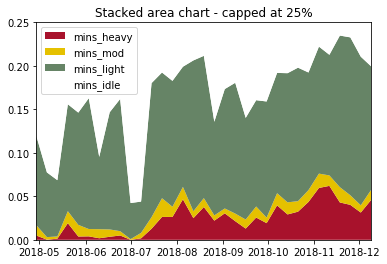

In [26]:
activity_stack(df)

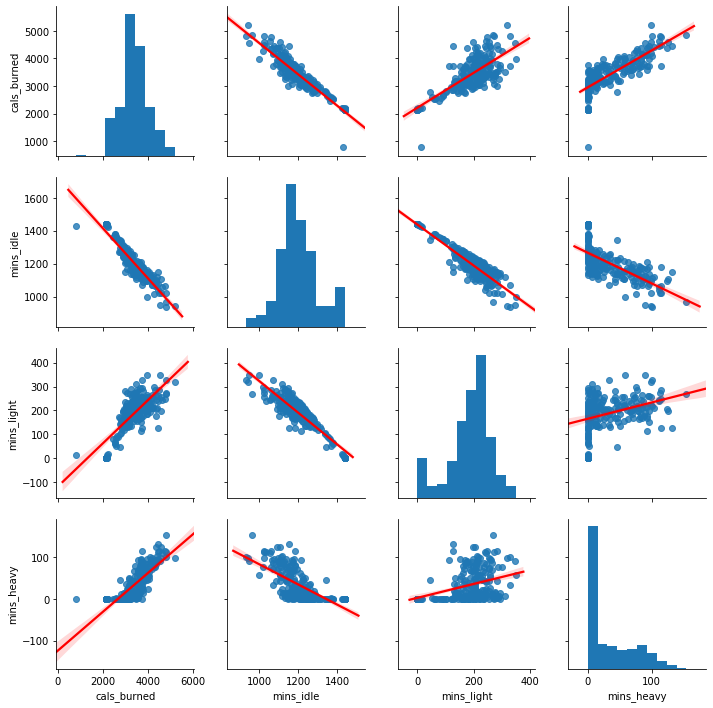

In [16]:
sns.pairplot(df[['cals_burned','mins_idle','mins_light','mins_heavy']],kind="reg", plot_kws={'line_kws':{'color':'red'}})

### Floors: Major outliers in the increased-activity segment

Floors spikes 9 times, suggesting there is either a stress-test, climb, bike ride, or some other unusual activity involving high increases in elevation. The heatmap does not reveal a direct correlation between floors and any other variable, suggesting that the elevation-changing activity is a transplanting some other elevated activity that would otherwise occur.

To investigate further, we've pulled these 9 dates:

In [ ]:
df[df.flrs >= 50]

What we found was more confusing than not. One would expect changing elevation from 750 to 2000 feet would require more than light exertion, however the moderate and heavy values do not support such an increase. The only conceivable way these values match up is if the elevation change occured during times of light activity, such as a non-brisk walk.

That, or the fitbit was faulty.

In [ ]:
def all_box_plots(df, x_col='week_day'):
    new_df = df.copy()
    new_df = new_df.sort_values(by=x_col)
    for col in df_limit_numerics(df).columns:
        
        plt.figure(figsize=(7,5))
        sns.boxplot(data=new_df,x=x_col,y=col,showmeans=True)

        plt.hlines(df[col].mean(),0,6, color='blue')
        plt
        plt.ylabel(col)
        plt.show()

In [ ]:
all_box_plots(df[['cals_burned','steps','dist','activity_cals','week_day']],x_col='week_day')

In [ ]:
df.head(2)